# PK Modelling Project - Mirtazapine

In [1]:
# Import basic dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import time
import pickle

# Import local scikit-pk (skpk) library - https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
import sys
sys.path.append(r'C:\Users\klty0\Desktop\scikit-pk\src')
# sys.path.append(r'C:\Users\Kenneth Leung\Desktop\scikit-pk\src')

import skpk

# Import ODE modules
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import differential_evolution

#### Data Preparation
Creating list of lists with elements [subject_id, gender, age mean, age std]  
For gender, 0 = Male and 1 = Female

In [2]:
list_of_attr = [
    [1,0,24,4],
    [2,0,25,5],
    [3,0,25,4], 
    [4,0,51,8], 
    [5,0,68,5], 
    [6,0,33,6], 
    [7,0,69,3], 
    [8,0,21,1], 
    [9,0,23,4], 
    [10,0,27,9], 
    [11,0,28,6], 
    [12,0,22,1], 
    [13,1,23,3], 
    [14,1,51,4], 
    [15,1,40,8], 
    [16,1,68,3], 
    [17,1,23,6],
    [18,0,23,4],
    [19,0,25,4],
    [20,0,25,4],
    [21,0,32,4],
    [22,0,33,6],
    [23,0,69,3],
    [24,0,23,4],
    [25,0,24,4],
    [26,0,25,4],
    [27,0,26,7],
    [28,0,29,7],
    [29,0,30,8],
    [30,0,33,7],
    [31,0,32,4],
    [32,0,23,4],
    [33,0,25,4],
    [34,0,32,4],
    [35,0,23,4],
    [36,0,25,4],
    [37,0,25,4],
    [38,0,23,4],
    [39,1,40,8],
    [40,1,68,3],
    [41,1,23,4],
    [42,1,34,10],
]

In [3]:
df_attr = pd.DataFrame(list_of_attr, columns = ['subject_id','gender','age_mean','age_sd'])

In [4]:
# Create dataframe of PK parameters (Subject ID, Cmax mean, Cmax SD, Tmax mean, Tmax SD, AUC mean, AUC SD, Study Reference)
list_of_pk_paras = [
    [1, 32.3, 11.4, 1.65, 0.70, 345, 103, 20, 'Single', 15],
    [2, 32.5, 9.7, 1.50, 0.60, 281, 83, 21, 'Single', 15],
    [3, 31.6, 12.8, 1.82, 0.71, 216, 46, 22, 'Single', 15],
    [4, 42.5, 16.3, 1.20, 0.30, 362, 66, 23, 'Single', 15],
    [5, 40.6, 13.8, 1.45, 0.73, 486, 161, 24, 'Single', 15],
    [6, 32.1, 8.1, 1.67, 0.65, 355, 199, 25, 'Single', 20],
    [7, 48.4, 20.1, 1.59, 0.74, 647, 294, 25, 'Single', 20],
    [8, 67.7, 20.6, 1.04, 0.10, 459, 136, 26, 'Single', 30],
    [9, 74.4, 23.5, 1.41, 0.74, 614, 177, 27, 'Single', 30],
    [10, 56.1, 13.9, 1.42, 0.56, 562, 134, 28, 'Single', 30],
    [11, 74.5, 37.8, 1.53, 0.78, 570, 137, 29, 'Single', 30],
    [12, 113.0, 55.8, 1.21, 0.40, 808, 285, 26, 'Single', 45],
    [13, 42.0, 8.2, 1.58, 0.68, 445, 94, 21, 'Single', 15],
    [14, 24.7, 6.9, 1.80, 0.80, 397, 218, 23, 'Single', 15],
    [15, 36.9, 11.3, 1.72, 1.00, 673, 248, 25, 'Single', 20],
    [16, 45.6, 20.2, 2.03, 1.64, 770, 270, 25, 'Single', 20],
    [17, 88.8, 38.7, 2.09, 1.84, 950, 298, 29, 'Single', 30],
    [18, 34.2, 13.4, 1.54, 0.51, 294, 100, 30, 'Multiple', 15],
    [19, 39.0, 12.0, 2.20, 1.50, 409, 116, 31, 'Multiple', 15],
    [20, 41.8, 7.7, 1.47, 0.75, 252, 48, 22, 'Multiple', 15],
    [21, 30.6, 7.8, 2.02, 1.11, 282, 51, 32, 'Multiple', 15],
    [22, 45.9, 24.3, 1.33, 0.43, 386, 170, 25, 'Multiple', 20],
    [23, 51.6, 29.4, 2.41, 1.66, 693, 357, 25, 'Multiple', 20],
    [24, 84.2, 36.5, 1.62, 0.82, 618, 205, 30, 'Multiple', 30],
    [25, 76.0, 33.0, 1.99, 1.65, 589, 142, 33, 'Multiple', 30],
    [26, 80.0, 24.0, 2.60, 1.40, 900, 254, 31, 'Multiple', 30],
    [27, 55.0, 8.9, 2.96, 1.24, 630, 160, 34, 'Multiple', 30],
    [28, 80.4, 18.5, 1.10, 0.30, 706, 235, 35, 'Multiple', 30],
    [29, 62.5, 15.8, 2.10, 1.08, 635, 196, 36, 'Multiple', 30],
    [30, 89.0, 21.0, 1.36, 0.39, 761, 140, 37, 'Multiple', 30],
    [31, 63.8, 16.8, 2.08, 0.93, 553, 96, 32, 'Multiple', 30],
    [32, 118.3, 47.3, 1.33, 0.85, 908, 308, 30, 'Multiple', 45],
    [33, 113.0, 29.0, 2.90, 1.80, 1350, 353, 31, 'Multiple', 45],
    [34, 102.1, 37.5, 1.79, 1.03, 786, 176, 32, 'Multiple', 45],
    [35, 141.2, 40.6, 1.06, 0.24, 1135, 247, 30, 'Multiple', 60],
    [36, 158.0, 41.0, 2.70, 1.60, 1793, 447, 31, 'Multiple', 60],
    [37, 181.0, 44.0, 3.10, 1.70, 2149, 476, 31, 'Multiple', 75],
    [38, 227.5, 31.1, 1.67, 0.58, 1797, 446, 30, 'Multiple', 80],
    [39, 59.9, 21.4, 2.33, 1.62, 769, 234, 25, 'Multiple', 20],
    [40, 62.0, 27.6, 2.31, 1.43, 860, 238, 25, 'Multiple', 20],
    [41, 81.7, 26.9, 2.29, 1.03, 958, 272, 34, 'Multiple', 30],
    [42, 80.0, 16.0, 1.39, 0.42, 785, 173, 37, 'Multiple', 30],
]

In [5]:
df_pk_paras = pd.DataFrame(list_of_pk_paras, columns = ['subject_id','Cmax_mean','Cmax_sd','Tmax_mean','Tmax_sd',
                                                        'AUC_mean','AUC_sd','reference','dosing', 'dose'])
df_pk_paras

,subject_id,Cmax_mean,Cmax_sd,Tmax_mean,Tmax_sd,AUC_mean,AUC_sd,reference,dosing,dose
0,1,32.3,11.4,1.65,0.70,345,103,20,Single,15
1,2,32.5,9.7,1.50,0.60,281,83,21,Single,15
2,3,31.6,12.8,1.82,0.71,216,46,22,Single,15
3,4,42.5,16.3,1.20,0.30,362,66,23,Single,15
4,5,40.6,13.8,1.45,0.73,486,161,24,Single,15
5,6,32.1,8.1,1.67,0.65,355,199,25,Single,20
6,7,48.4,20.1,1.59,0.74,647,294,25,Single,20
7,8,67.7,20.6,1.04,0.10,459,136,26,Single,30
8,9,74.4,23.5,1.41,0.74,614,177,27,Single,30
9,10,56.1,13.9,1.42,0.56,562,134,28,Single,30


#### Setup skpk Model instance

In [6]:
C0 = skpk.Cmt(0, 'Absorption (GI Tract)')
C1 = skpk.Cmt(1, 'Central')
C2 = skpk.Cmt(2, 'Peripheral')
C3 = skpk.Cmt(3, 'External / Elimination')
pk_model = skpk.Model('PK Model - Mirtazapine')

0-Absorption (GI Tract) compartment successfully generated
1-Central compartment successfully generated
2-Peripheral compartment successfully generated
3-External / Elimination compartment successfully generated
 Model named PK Model - Mirtazapine successfully generated


#### Read in trajectory data

In [7]:
# Reading pickle file (stored trajectory data) generated from Python DE earlier
with open('trajectory_data_python_v1.pkl', 'rb') as handle:
    raw_trajectory_data = pickle.load(handle)

In [8]:
trajectories = list(raw_trajectory_data)
trajectories

[{1: <zip at 0x2568cd5fe88>},
 {2: <zip at 0x2568cd5f9c8>},
 {3: <zip at 0x2568cd5f748>},
 {4: <zip at 0x2568cd5f3c8>},
 {5: <zip at 0x256895ae108>},
 {6: <zip at 0x2568c3a8208>},
 {7: <zip at 0x2568cd31b08>},
 {8: <zip at 0x2568cd31fc8>},
 {9: <zip at 0x2568cd7af88>},
 {10: <zip at 0x2568cd7a688>},
 {11: <zip at 0x2568cd7aa48>},
 {12: <zip at 0x2568cd7a188>},
 {13: <zip at 0x2568cd7a388>},
 {14: <zip at 0x2568cd56648>},
 {15: <zip at 0x2568cd56c08>},
 {16: <zip at 0x2568cd56988>},
 {17: <zip at 0x2568cd56708>},
 {18: <zip at 0x2568cd46c88>},
 {19: <zip at 0x2568cd56148>},
 {20: <zip at 0x2568cd56fc8>},
 {21: <zip at 0x2568cd5bac8>},
 {22: <zip at 0x2568cd3f848>},
 {23: <zip at 0x2568cd47048>},
 {24: <zip at 0x2568cd880c8>},
 {25: <zip at 0x2568cd86288>},
 {26: <zip at 0x2568cd5b848>},
 {27: <zip at 0x2568cd5b648>},
 {28: <zip at 0x2568cd5b0c8>},
 {29: <zip at 0x2568cd5b308>},
 {30: <zip at 0x2568cd5b988>},
 {31: <zip at 0x2568cd59608>},
 {32: <zip at 0x2568cd59448>},
 {33: <zip at 0x2

In [9]:
# Unpacking the concentration time trajectory data for each subject
list_subject_data = []

for i in range(1,len(trajectories)+1):
    data = trajectories[i-1][i]
    time_x, conc_y = zip(*data)
    subject_df = pd.DataFrame({'time':time_x,
                                'conc':conc_y})
    list_subject_data.append(subject_df)

In [10]:
list_subject_data[0].head(60)

,time,conc
0,0.00,0.000000
1,0.03,7.911438
2,0.07,9.959780
3,0.10,11.303240
4,0.13,12.575035
5,0.17,14.198751
6,0.20,15.338160
7,0.23,16.414361
8,0.27,17.735103
9,0.30,18.708294


In [11]:
# Obtain 18 sample points from each trajectory
sampling_timepoints = [0.00, 0.23, 0.50, 0.77, 1.00, 
                       1.23, 1.50, 1.83, 2.00, 3.00, 
                       4.00, 6.00, 8.00, 11.01, 15.01, 
                       20.01, 24.01, 36.02]

#### Generate sample data points from trajectory data

In [12]:
list_of_samples = []

for df in list_subject_data:
    sample_df = df.loc[df['time'].isin(sampling_timepoints)]
    sample_df.reset_index(drop=True, inplace=True)
    list_of_samples.append(sample_df)

In [13]:
list_of_samples[2]

,time,conc
0,0.00,0.000000
1,0.23,19.909697
2,0.50,24.157950
3,0.77,27.190423
4,1.00,29.106653
5,1.23,30.372336
6,1.50,31.197108
7,1.83,31.600773
8,2.00,31.492007
9,3.00,28.993017


#### Setup PK model

In [14]:
# Instantiate the 3 relevant compartment instances of the 2-compartment model
C0 = skpk.Cmt(0, 'Absorption (GI Tract)')
C1 = skpk.Cmt(1, 'Central')
C2 = skpk.Cmt(2, 'Peripheral')
C3 = skpk.Cmt(3, 'External / Elimination')

pkmodel = skpk.Model('PK Model - Mirtazapine')
pkmodel.add_cmt([C0, C1, C2, C3])

0-Absorption (GI Tract) compartment successfully generated
1-Central compartment successfully generated
2-Peripheral compartment successfully generated
3-External / Elimination compartment successfully generated
 Model named PK Model - Mirtazapine successfully generated


#### Functions for optimization

In [15]:
# Pre-defined parameters
F = 0.497 # Bioavailability
n = 3 # Number of compartments (+1 for GI tract compartment for oral route)

period_start = 0
period_end = 72
intervals = 2160
time_horizon = np.around(np.linspace(period_start, period_end, intervals), decimals=2)

In [16]:
# Define dcdt function of ODE (dot multiplication of coefficient matrix and concentration)
def dC(t,C,A):
   
    # Dot multiplication of A coefficient matrix (n x n) with concentration vector C (n x 1) 
    dCdt = np.dot(A, C)
    
    # Returns dCdt as n x 1 vector (dC0/dt, dC1/dt, dC2/dt)
    return dCdt

In [17]:
# Create function that generates coefficient matrix and runs solve_ivp
def ode_solver(p, subject_id):
    
    ka, k12, k21, ke = p    
       
    # Add links based on parameters (p) passed as arguments
    pk_model.add_link([(C0, C1, ka), (C1, C2, k12), (C2, C1, k21), (C1, C3, ke)])
    full_matrix = pk_model.get_matrix()
    
    # Ignoring elimination compartment (C3), so we truncate matrix size by 1 to form coefficient matrix (n is exclusive)
    A_matrix = full_matrix[0:n,0:n]

    # Initial concentration
    dose_mg = df_pk_paras[df_pk_paras.subject_id == 1]['dose'][0]
    
    # Convert dose from mg to ug
    dose_ug = dose_mg * 1000
    
    C_initial = np.zeros(n)
    C_initial[0] = dose_ug * F # C0 in GI tract compartment, and taking bioavailability into account
    
    # Reshaping C_initial into 1 dimension to pass into solve_ivp
    C_initial_1dim = C_initial.reshape(n,)

    # Solving ODE
    output = solve_ivp(fun=dC, t_span=[period_start, period_end], y0 = C_initial_1dim, t_eval = time_horizon, args=(A_matrix,))
    
    return output

In [18]:
# Objective function (for optimization using sampled data points)
def objective_func_sample_data(p, subject_id):
    
    # Obtaining ODE output after solving
    output = ode_solver(p, subject_id)

    # Get ODE-predicted plasma concentration of central compartment
    sample_df = list_of_samples[subject_id - 1]
    output_dict = dict(zip(output.t, output.y[1])) # Combining time (x-axis) with conc (y-axis) together as dict
    t_sample = sample_df['time'].values
    y_pred = [output_dict[x] for x in t_sample] # Obtaining predicted conc values based on time intervals from sample data
    y_actual = sample_df['conc'].values
      
    # Calculate RMSE
    error = y_actual - y_pred
    # normalized_error = error / y_actual.max() # Use this if intend to calculate normalized RMSE
    squared_error = np.power(error,2)
    sum_error = np.sum(squared_error)
    mse = sum_error / y_actual.shape[0]
    rmse = np.sqrt(mse)
    return rmse

In [19]:
# Plot best fit from best results (differential evolution)
def plot_best_fit(p, subject_id):
       
    output = ode_solver(p, subject_id)
    plt.plot(output.t,output.y[1])
    plt.scatter(list_of_samples[subject_id-1]['time'], list_of_samples[subject_id-1]['conc'])

In [20]:
bounds = [(0.0, 1.0), (30.0, 90.0), (0.0, 15.0),(0.0, 35.0)]

In [267]:
# Solve for several subjects (Pre-test)
de_results = []

# Small test
for subject_id in range(1, 3):
    start = time.perf_counter()
    best_result = differential_evolution(objective_func_sample_data, bounds, args = (subject_id,), maxiter = 15)
    de_results.append([subject_id, best_result.x, best_result.fun])
    finish = time.perf_counter()
    print(f'{subject_id} DE completed in {round((finish - start),2)} seconds')
    print(best_result.x, best_result.fun)

1 DE completed in 426.22 seconds
[ 0.11857604 87.81349864  8.02013887 21.64401576] 0.06720966770661939
2 DE completed in 517.79 seconds
[ 0.15626852 41.63411136  3.35413202 26.79836069] 0.11487597738841306


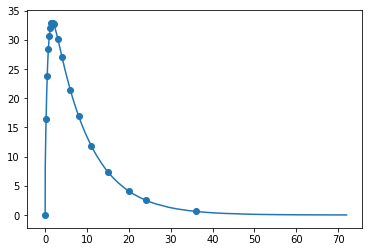

In [275]:
plot_best_fit(de_results[0][1],1) # Get first row (index 0), and access best k values (p), subject_id)

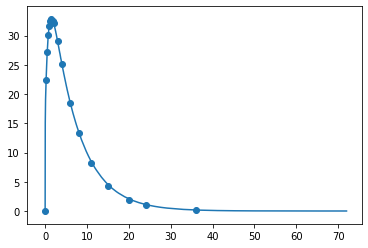

In [276]:
plot_best_fit(de_results[1][1],2) # Get first row (index 0), and access best k values (p), subject_id)

In [22]:
# Run for all 42 subjects
de_results = []

for subject_id in range(1, len(list_of_samples)+1):
    
    start = time.perf_counter()
    best_result = differential_evolution(objective_func_sample_data, bounds, args = (subject_id,), maxiter = 15)
    de_results.append([subject_id, best_result.x, best_result.fun])
    
    finish = time.perf_counter()
    print(f'{subject_id} DE completed in {round((finish - start),2)} seconds')
    print(best_result.x, best_result.fun)

1 DE completed in 339.0 seconds
[ 0.11855455 86.88854404  7.93105446 21.64605987] 0.0736389835268978
2 DE completed in 385.14 seconds
[ 0.16091617 41.9550426   3.15702188 27.19370003] 0.015310568574437577
3 DE completed in 443.37 seconds
[ 0.2554712  86.95186462  2.42230065 34.05522235] 0.125844944752329
4 DE completed in 411.8 seconds
[ 0.14370981 68.78313556 10.49855444 20.57786347] 0.13820824098230708
5 DE completed in 374.81 seconds
[ 0.09426647 40.24914018 11.85330042 15.22203955] 0.8322269818762066
6 DE completed in 922.05 seconds
[ 0.11016399 86.32440095  8.4907361  20.97343378] 0.07066738736879913
7 DE completed in 357.96 seconds
[ 0.08861838 54.74502044 13.52132798 11.68237409] 0.03136800924692328
8 DE completed in 328.71 seconds
[ 0.18011155 41.53178267  9.76638541 16.25292568] 0.20170077964759722
9 DE completed in 365.09 seconds
[ 0.60935356 86.69021623  1.68284139 12.99147985] 3.191252688591597
10 DE completed in 386.67 seconds
[ 0.12066658 43.05487264  8.53496339 13.241833

In [23]:
# Creating dataframe to store results
df_de_results = pd.DataFrame(de_results, columns = ['subject_id', 'k_values','error'])

In [36]:
ka_values = []
k12_values = []
k21_values = []
ke_values = []

for i in range(len(df_de_results)):
    ka_values.append(df_de_results['k_values'].values[i][0])
    k12_values.append(df_de_results['k_values'].values[i][1])
    k21_values.append(df_de_results['k_values'].values[i][2])
    ke_values.append(df_de_results['k_values'].values[i][3])
    
df_de_results['ka'] = ka_values
df_de_results['k12'] = k12_values
df_de_results['k21'] = k21_values
df_de_results['ke'] = ke_values

In [40]:
# Merge subject attributes and dosing details
df_de_results = pd.merge(df_de_results, df_attr, on='subject_id')

df_dosing = df_pk_paras[['subject_id', 'dosing', 'dose']]
df_de_results = pd.merge(df_de_results, df_dosing, on='subject_id')

In [41]:
df_de_results.head()

,subject_id,k_values,ka,k12,k21,ke,error,gender,age_mean,age_sd,dosing,dose
0,1,"[0.11855455,86.88854404,7.93105446,21.64605987]",0.118555,86.888544,7.931054,21.646060,0.073639,0,24,4,Single,15
1,2,"[0.16091617,41.9550426,3.15702188,27.19370003]",0.160916,41.955043,3.157022,27.193700,0.015311,0,25,5,Single,15
2,3,"[0.2554712,86.95186462,2.42230065,34.05522235]",0.255471,86.951865,2.422301,34.055222,0.125845,0,25,4,Single,15
3,4,"[0.14370981,68.78313556,10.49855444,20.57786347]",0.143710,68.783136,10.498554,20.577863,0.138208,0,51,8,Single,15
4,5,"[0.09426647,40.24914018,11.85330042,15.22203955]",0.094266,40.249140,11.853300,15.222040,0.832227,0,68,5,Single,15


In [42]:
# Export dataframe
# df_de_results.to_csv('df_de_results_v2.csv',index=False)

In [21]:
# Import dataframe
df_de_results = pd.read_csv('df_de_results_v2.csv')

In [22]:
list_of_cov = [] # List to store coefficient of variation (CoV) across all the k
k_stats = []

# Function to display statistics, density plot and histograms, and to store values
def show_stats(df, col_name):
    ax = df[col_name].plot(kind='hist', secondary_y = True)
    df[col_name].plot.density(bw_method=1); # Orange
    # df_de_results[col_name].plot.density(); # Green line
    mean = df[col_name].describe()['mean']
    std = df[col_name].describe()['std']
    cov = std / mean
    list_of_cov.append([col_name, cov])
    k_stats.append([col_name, mean, std])
    print(df[col_name].describe())
    print('Coefficient of variation = ',cov)

count    42.000000
mean      0.215868
std       0.207809
min       0.054545
25%       0.116672
50%       0.142973
75%       0.184145
max       1.000000
Name: ka, dtype: float64
Coefficient of variation =  0.9626677482101835


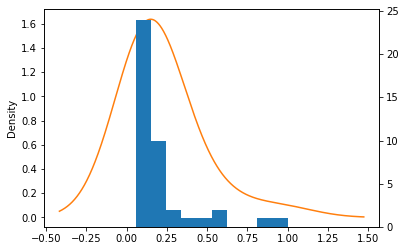

In [23]:
show_stats(df_de_results, 'ka')

count    42.000000
mean     61.546844
std      19.609905
min      30.000000
25%      42.230000
50%      62.904833
75%      79.764010
max      90.000000
Name: k12, dtype: float64
Coefficient of variation =  0.3186175637422266


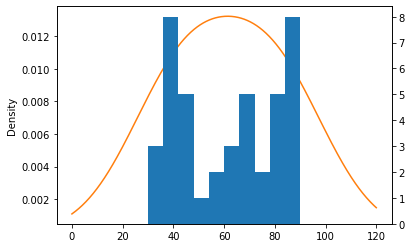

In [24]:
show_stats(df_de_results, 'k12')

count    42.000000
mean      7.741424
std       3.857692
min       1.023739
25%       4.410598
50%       8.041050
75%      10.423672
max      15.000000
Name: k21, dtype: float64
Coefficient of variation =  0.498318061759598


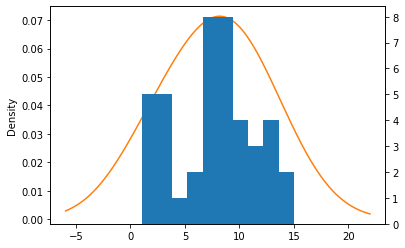

In [25]:
show_stats(df_de_results, 'k21')

count    42.000000
mean     13.784755
std       7.190257
min       3.559836
25%       9.287695
50%      11.881241
75%      17.856034
max      34.055222
Name: ke, dtype: float64
Coefficient of variation =  0.5216093314200068


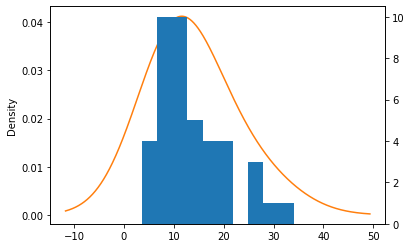

In [26]:
show_stats(df_de_results, 'ke')

In [27]:
pd.DataFrame(k_stats, columns = ['k','mean','std'])

,k,mean,std
0,ka,0.215868,0.207809
1,k12,61.546844,19.609905
2,k21,7.741424,3.857692
3,ke,13.784755,7.190257


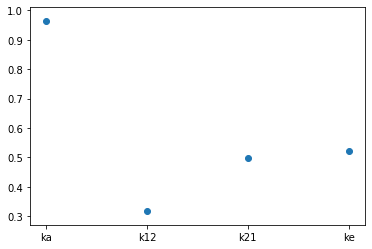

In [28]:
plt.scatter(*zip(*list_of_cov));

### Review k values for Single Dosing subjects

In [29]:
df_de_results_single = df_de_results.loc[df_de_results['dosing'] == 'Single']
list_of_cov = [] # List to store coefficient of variation (CoV) across all the k
k_stats = []

count    17.000000
mean      0.178681
std       0.157613
min       0.054545
25%       0.094266
50%       0.120667
75%       0.180112
max       0.609354
Name: ka, dtype: float64
Coefficient of variation =  0.8820944979592231


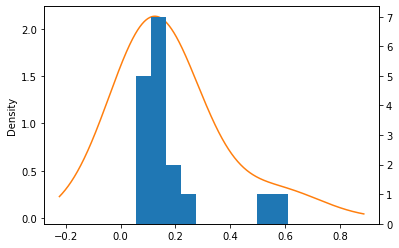

In [30]:
show_stats(df_de_results_single,'ka')

count    17.000000
mean     59.210231
std      21.048795
min      30.000000
25%      41.531783
50%      54.745020
75%      85.376661
max      86.951865
Name: k12, dtype: float64
Coefficient of variation =  0.3554925383413588


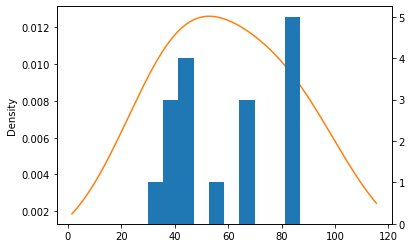

In [31]:
show_stats(df_de_results_single,'k12')

count    17.000000
mean      7.978354
std       3.775985
min       1.682841
25%       5.521204
50%       8.532841
75%      10.498554
max      13.521328
Name: k21, dtype: float64
Coefficient of variation =  0.473278684882898


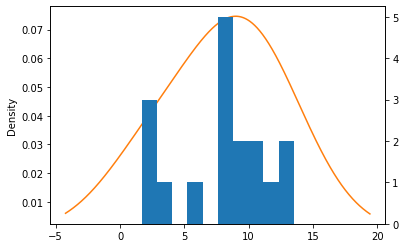

In [32]:
show_stats(df_de_results_single,'k21')

count    17.000000
mean     16.498147
std       6.881593
min       7.870886
25%      11.682374
50%      15.222040
75%      20.577863
max      34.055222
Name: ke, dtype: float64
Coefficient of variation =  0.417113107766423


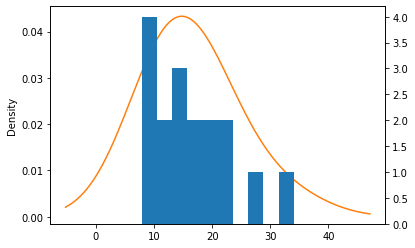

In [33]:
show_stats(df_de_results_single,'ke')

In [34]:
pd.DataFrame(k_stats, columns = ['k','mean','std'])

,k,mean,std
0,ka,0.178681,0.157613
1,k12,59.210231,21.048795
2,k21,7.978354,3.775985
3,ke,16.498147,6.881593


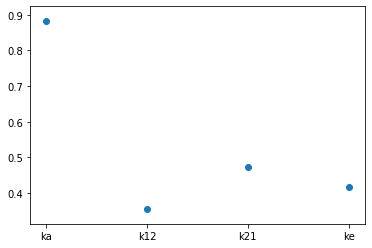

In [35]:
plt.scatter(*zip(*list_of_cov));

#### Review k values for Multiple Dosing subjects

In [36]:
df_de_results_multiple = df_de_results.loc[df_de_results['dosing'] == 'Multiple']
list_of_cov = [] # List to store coefficient of variation (CoV) across all the k
k_stats = []

count    25.000000
mean      0.241155
std       0.235726
min       0.089755
25%       0.127628
50%       0.148874
75%       0.189542
max       1.000000
Name: ka, dtype: float64
Coefficient of variation =  0.9774868954155568


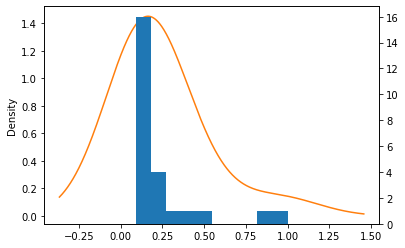

In [37]:
show_stats(df_de_results_multiple, 'ka')

count    25.000000
mean     63.135740
std      18.843351
min      32.336089
25%      46.187928
50%      63.997095
75%      79.710349
max      90.000000
Name: k12, dtype: float64
Coefficient of variation =  0.2984577443458274


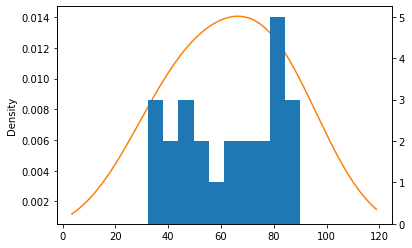

In [38]:
show_stats(df_de_results_multiple, 'k12')

count    25.000000
mean      7.580312
std       3.981316
min       1.023739
25%       4.040396
50%       7.559553
75%      10.199024
max      15.000000
Name: k21, dtype: float64
Coefficient of variation =  0.525217865175471


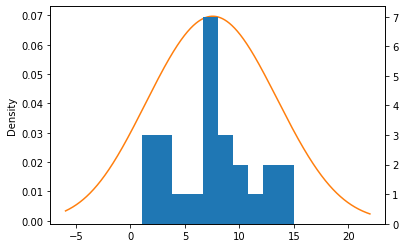

In [39]:
show_stats(df_de_results_multiple, 'k21')

count    25.000000
mean     11.939648
std       6.927353
min       3.559836
25%       8.081584
50%       9.817134
75%      12.612840
max      29.515564
Name: ke, dtype: float64
Coefficient of variation =  0.5801974127584119


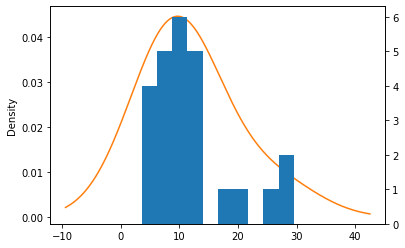

In [40]:
show_stats(df_de_results_multiple, 'ke')

In [41]:
pd.DataFrame(k_stats, columns = ['k','mean','std'])

,k,mean,std
0,ka,0.241155,0.235726
1,k12,63.135740,18.843351
2,k21,7.580312,3.981316
3,ke,11.939648,6.927353


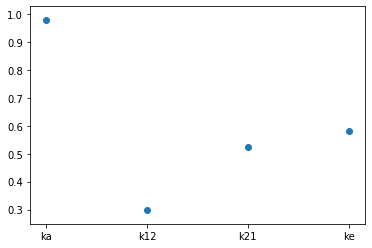

In [42]:
plt.scatter(*zip(*list_of_cov));